In [ ]:
# for colab
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
project_dir = '/content/gdrive/My Drive/ColabNotebooks/AI'
import sys
sys.path.insert(0, project_dir)

# Step by step mcts

In [129]:
from models import Model, Trainer
from env_test import Env
from mcts import MCTS

class dotdict(dict):
    def __getattr__(self, name):
        return self[name]

model =Model()# LSTMTagger()#Model()
env = Env(1,1)

args = dotdict({'cpuct':0.5, 'iters':2000})

In [130]:
%matplotlib inline

In [131]:

mcts2 = MCTS(env, model, args)
val = list(mcts2.sampling())
print(len(val))
#val = [v for v in val if v.parent and v.parent.times_visited > 2]
#print(len(val))
t = Trainer(env, batch_size=50)
#t.train_model(val, model, batch_size=10, net_iters=300)
#examples = deque([], maxlen=1000)

batch = t.get_batch(val, batch_size=5)
#for b in t.transform_bach_as_input(batch):
#    print(b)
#import matplotlib.pyplot as plt

#plt.plot(t.loss_backet)
#plt.show()

ieB1A ieB1A1 0
ieB1A1 ieB1A1s 0
ieB1A1s ieB1A1sC 0
ieB1A1sC ieB1A1sCs 0
ieB1A1sCs ieB1A1sCse 0
ieB1A1sCse ieB1A1sCsee 0
3339


In [ ]:
def get_y(Xval):
    Xval

In [136]:
from sklearn.model_selection import train_test_split

len(val)
train = {'1o1':[], '1o2':[], '1o3':[]}
test = {'1o1':[], '1o2':[], '1o3':[]}
for k in train:
    env = Env(1,int(k[2]))
    mcts2 = MCTS(env, model, args)
    X = list(mcts2.sampling())
    y = t.transform_bach_as_input(X)
    train[k]

TypeError: transform_bach_as_input() missing 1 required positional argument: 'model'

In [135]:
#print([(v.formula, v.history_data['time']) for v in val if 'ie' in v.formula])


# Embeding actions

In [ ]:
import numpy as np
from collections import defaultdict
treegramm_count = defaultdict(lambda: defaultdict(int))

treegramm_count

def delta(dict1, dict2):
    #print(np.sum(list(dict1.values()), dict1.values())
    return np.sum(list(dict1.values())) - np.sum(list(dict2.values()))

def betreegrams(val, env, treegramm_count):
    results = {}
    treegramm_count = defaultdict(lambda: defaultdict(int))
    for v in val[:100]:
        #print(env.result, v.formula)
        env.calc_formula(v.formula)
        results[v.formula] = env.result.copy()
        if env.result['o'] == env.out: print(v.formula)
    #print(results)
    for v in val[:100]:
        # beegram
        for i in range(len(v.formula)-2):
            # beegram
            #print(i, results[v.formula[:i]], v.formula[:i])
            if i > 0 and delta(results[v.formula[:i]], results[v.formula[:i + 1]]) != 0:
                
                treegramm_count[v.formula[i-1]][v.formula[i]] += 1
                treegramm_count[v.formula[i-1:i+1]][v.formula[i+1]] += 1
            if i > 0 and delta(results[v.formula[:i]], results[v.formula[:i + 2]]) != 0:
                # ?? peace of sheet!! eB1 in 1ABCieB1e we could remove it...
                #print('aa', v.formula, v.formula[:i+1], results[v.formula[:i]], results[v.formula[:i+2]],
                #      v.formula[i-1], v.formula[i-1:i+2]
                #     )
                treegramm_count[v.formula[i-1]][v.formula[i]] += 1
                treegramm_count[v.formula[i-1:i+1]][v.formula[i+1]] += 1
        i = len(v.formula) - 1
        if i >= 0 and delta(results[v.formula[:i]], results[v.formula[:i + 1]]) != 0:
            treegramm_count[v.formula[i-1]][v.formula[i]] += 1
    return treegramm_count, results
    
            
t, r = betreegrams(val, env, treegramm_count)                

In [ ]:
t

In [ ]:
def count_grams(val, env, treegramm_count):
    results = {}
    treegramm_count = defaultdict(lambda: defaultdict(int))
    treegramm_list = []
    for v in val:
        #print(env.result, v.formula)
        env.calc_formula(v.formula)
        results[v.formula] = env.result.copy()
        if env.result['o'] == env.out: print(v.formula)
    #print(results)
    for v in val:
        # beegram
        for i in range(len(v.formula)-2):
            if i>0 and delta(results[v.formula[:i+1]], results[v.formula[:i+2]]):
                #print(v.formula)
                #treegramm_count[v.formula[i:i+1]][v.formula[i+1:i+2]] += 1
                treegramm_count[v.formula[i-1:i+1]][v.formula[i+1:i+2]] += 1
                #treegramm_list.append([list(v.formula[i-1:i+1]), v.formula[i+1:i+2]])
                treegramm_list.append([list(v.formula[i-1:i]), v.formula[i:i+1]])
                treegramm_list.append([list(v.formula[i:i+1]), v.formula[i+1:i+2]])
            # beegram
            
        #i = len(v.formula) - 1
        #if i >= 0 and delta(results[v.formula[:i]], results[v.formula[:i + 1]]) != 0:
            #treegramm_count[v.formula[i-1]][v.formula[i]] += 1
    return treegramm_count, treegramm_list, results

t, tl, r = count_grams(val, env, treegramm_count)   
#tl

In [ ]:
len(tl)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [ ]:
CONTEXT_SIZE = 1
EMBEDDING_DIM = 10
trigrams = tl#[([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
           # for i in range(len(test_sentence) - 2)]
# print the first 3, just so you can see what they look like
print(trigrams[:3])

vocab = set(env.action_space)
word_to_ix = {word: i for i, word in enumerate(env.action_space)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

In [ ]:
dataframe = np.vstack([model.embeddings(torch.tensor([i])).data.numpy() for i in range(8)])

In [ ]:
from sklearn.decomposition import PCA


#dataframe = np.concatenate([samples, test], axis=0)#[train, test, samples], axis=0)

pca = PCA(n_components=2)
X_feature_reduced = pca.fit(dataframe).transform(dataframe)
# map word vectors onto 2d plane with PCA. Use good old sklearn api (fit, transform)
# after that, normalize vectors to make sure they have zero mean and unit variance
#word_vectors_pca = # YOUR CODE

# and maybe MORE OF YOUR CODE here :)

In [ ]:
plt.scatter(x=X_feature_reduced[:,0], y=X_feature_reduced[:,1])

In [ ]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [ ]:
draw_vectors(X_feature_reduced[:, 0], X_feature_reduced[:, 1], token=list(vocab))

In [48]:
class def_zer():
    def __init__(self):
        return np.zeros([8])


defaultdict(__main__.def_zer, {})

In [120]:
from collections import defaultdict
j= defaultdict(int)
prj = np.zeros([8])

In [121]:
model = sm

In [126]:
clval = t.clean_unpredict_node(val)
sm.train(clval)
for f in clval:
    last = -1
    if f.formula and f.formula[-1:]=='e' and len(f.history_data['next_node_ind']) > last:
        print(f.times_visited, f.formula, f.history_data['next_node_ind'][last])                                       
        j[f.history_data['next_node_ind'][last]] += 1
        x = model.get_observation(f.formula, env)
        prj += model.predict(x)[0].reshape([8])
        

#[(f.formula, f.history_data['next_node_ind'][0], j[f.history_data['next_node_ind'][0]] += 1) 

9 Be 0
67 e 0
10 1e 3
8 Ae 2
8 ee 1
7 se 1
9 Ce 0
3053 ie 2
38 iee 3
9 ise 7
7 i1e 3
2 e1e 7
1 e1eB1isCe 0
1 1se 2
2 eCe 7
1 eCeB1isCe 0
1 Aee 2
6 iBe 6
1 eie 4
1 eieB1isCe 0
1 1Be 2
1 Bse 4
1 eee 0
1 Cee 1
6 iie 3
1 Ase 4
1 1Ae 5
1 see 2
1 Bee 4
2 eBe 7
1 CAe 2
2 ABe 7
1 ABeB1isCe 0
1 ese 2
1 1ee 2
1 Aie 4
1 AieB1isCe 0
1 s1e 2
2 B1e 7
1 B1eB1isCe 0
1 C1e 2
1 eAe 2
2 A1e 7
1 A1eB1isCe 0
1 BBe 2
1 11e 2
8 iCe 2
1 iCeB1isCe 0
1 ACe 2
1 sse 2
1 e11B1isCe 0
1 CBe 2
6 iAe 6
2 BCe 7
1 BCeB1isCe 6
1 1Ce 2
1 eCBsACBBACsiie 0
1 AAe 6
1 BAe 4
1 BAeBe 4
2 sBe 7
1 sBeiiie 1
1 CCe 0
1 CCe1Ae 3
3 1ie 7
1 1ise 2
1 sCe 7
1 sCee 4
1 Bie 5
1 BieCe 5
1 ABBA11sCse 0
1 Cse 4
1 1s1A11sCse 0
1 Ae1A11sCse 0
1 sAe 4
1 B11A11sCse 0
1 eB1A11sCse 0
1 Cie 4
1 Be1A11sCse 0
1 e1sA11sCse 0
1 sie 4
1 1e1A11sCse 0
1 1A1A11sCse 0
1 A11A11sCse 0
1 eCCA11sCse 0
1 Bs111se 7
1 Bs111see 0
1 BC1A11sCse 0
1 sB1A11sCse 0
1 1i1A11sCse 0
1 BB1A11sCse 0
1 ABs11se 7
1 ABs11see 0
1 BA1A11sCse 0
1 CABA11sCse 0
1 BisA11sCse 0
1 s11A1

In [127]:
j

defaultdict(int, {0: 355, 1: 21, 2: 23, 3: 60, 4: 74, 5: 12, 6: 29, 7: 104})

In [128]:
prj

array([ 49.45104617, 451.56613214,   0.        ,  35.13626965,
        44.24567289,  33.83492633,  31.23223969,  32.53358301])

In [125]:
prj

array([ 1.75047951, 15.98464185,  0.        ,  1.24376176,  1.56621851,
        1.19769651,  1.10556601,  1.15163126])

In [19]:
[f.formula for f in val]

['',
 'B',
 'Be',
 'BeB',
 'BeBC',
 'BeBCs',
 'BeBCs1',
 'BeBCs1o',
 'e',
 'eA',
 'eAo',
 '1',
 '1B',
 '1B1',
 '1B1i',
 '1B1is',
 '1B1isA',
 '1B1isAB',
 '1B1isABi',
 '1B1isABio',
 's',
 'so',
 'C',
 'Co',
 'A',
 'AB',
 'AB1',
 'AB1i',
 'AB1is',
 'AB1isA',
 'AB1isAB',
 'AB1isABi',
 'AB1isABio',
 'i',
 'io',
 'o',
 '1e',
 '1eo',
 'Ae',
 'AeB',
 'AeB1',
 'AeB1i',
 'AeB1is',
 'AeB1isA',
 'AeB1isA1',
 'AeB1isA11',
 'AeB1isA11i',
 'AeB1isA11io',
 'B1',
 'B1o',
 'ee',
 'eeo',
 'se',
 'seB',
 'Ce',
 'Ce1',
 'Ce1i',
 'Ce1is',
 'Ce1isA',
 'Ce1isAB',
 'Ce1isABi',
 'Ce1isABio',
 'ie',
 'ieo',
 'is',
 'iso',
 'i1',
 'i1B',
 'i1B1',
 'i1B1i',
 'i1B1is',
 'i1B1isA',
 'i1B1isA1',
 'i1B1isA11',
 'i1B1isA11i',
 'i1B1isA11io',
 'A1',
 'A1o',
 '11',
 '11o',
 'e1',
 'e1B',
 'e1B1',
 'e1B1i',
 'e1B1is',
 'e1B1isA',
 'e1B1isA1',
 'e1B1isA11',
 'e1B1isA11i',
 'e1B1isA11io',
 'BB',
 'BBo',
 'C1',
 'C1o',
 'iB',
 'iBB',
 'iBB1',
 'iBB1i',
 'iBB1is',
 'iBB1isA',
 'iBB1isA1',
 'iBB1isA11',
 'iBB1isA11i',
 'iBB1is

# LSTM Model

1574
348
0 []
ii1C ii1CA 0
ii1CA ii1CA1 0
1 [array([0.26121113], dtype=float32), array([0.24729565], dtype=float32), array([0.24924605], dtype=float32)]
2 [array([0.2546848], dtype=float32), array([0.2668951], dtype=float32), array([0.25828367], dtype=float32)]


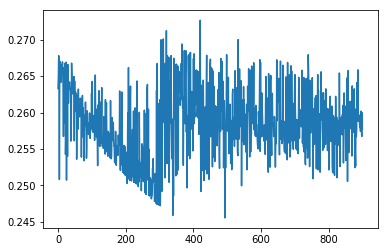

In [41]:
import numpy as np
from LSTMmodel import LSTMModel, mctsTrainer
#import torch
#from torch import Tensor, nn
#import torch.optim as optim
#from torch.autograd import Variable
#import torch.nn.functional as F
from env_test import Env
from mcts import MCTS

class dotdict(dict):
    def __getattr__(self, name):
        return self[name]

model = LSTMModel(4, 32, 8, 8)

env = Env()
stm = StModel(env)

args = dotdict({'cpuct':0.5, 'iters':1000})
mcts = MCTS(env, stm, args)
#val = list(mcts2.sampling())
val = t.clean_unpredict_node(val)
print(len(val))
val = [v for v in val if v.parent and v.parent.times_visited > 2]
print(len(val))


t = mctsTrainer(env, mcts, batch_size=10)

#t = Trainer(env, batch_size=20)
for i in range(3):
    print(i, t.loss_backet[-3:])
    mcts = MCTS(env, stm, args)
    
    #print(len(val), val[-1].history_data['time'], val[-1].formula) 
    
    #print('aa', val)
    #t.train_model(val, model, net_iters=300)
    val = list(mcts2.sampling())
    val = t.clean_unpredict_node(val)
# #examples = deque([], maxlen=1000)
#
#batch = t.get_batch(val)
#print(list(t.transform_bach_as_input(batch)[1]))

import matplotlib.pyplot as plt
#
plt.plot(t.loss_backet)
plt.show()

In [59]:
#torch.zeros(25) + 8
env.action_space.index('o')

2

# Stat model

In [103]:
class StModel:
    def __init__(self, env):
        self.env = env
        self.stat = np.random.rand(8, 8)
        self.vstat = np.random.rand(8)
        
    def train(self, val):
        self.stat = np.zeros([8, 8])
        self.predvst = defaultdict(list)
        self.vstat = np.zeros([8])
        for node in val:
            if node.formula:
                v = self.env.action_space.index(node.formula[0])
                nv = node.history_data['next_node_ind'][-1]
                nr = node.history_data['next_node_val'][-1]
                self.stat[v][nv] += 1
                self.predvst[v].append(nr)
        self.stat /= np.sum(self.stat, axis=0) + 0.0001
        for i, k in enumerate(self.predvst):
            self.vstat[i] = sum(self.predvst[k]) / len(self.predvst[k])
         
            
    def predict(self, formula):
        v = self.env.action_space.index(formula[-1])
        return self.stat[:, v], self.vstat[v]
    
    def get_observation(self, formula, env, time=0):
        return formula
            
sm = StModel(env)
sm.train(val)
sm.predict('Ai')

(array([0.05579398, 0.61802562, 0.        , 0.08154505, 0.04935621,
        0.0579399 , 0.06437767, 0.07296136]), 0.10704710676822293)

# Train LSTM

In [ ]:
t = mctsTrainer(env, mcts, batch_size=20)

def get_sorted_batch(val, batch_size=20):
    sort_val = sorted(val, key=lambda x: len(x.formula))
    i = np.random.randint(len(val) - batch_size)
    yield sort_val[i:i + batch_size]
    


In [ ]:
#sbach = list(get_sorted_batch(val))
#print(sbach[0])
#for i in sbach[0]: 
#    print(i.formula)

In [ ]:
for epoch in range(10):
    batch = list(get_sorted_batch(val))
    
    torch.cat([model.get_observation(n.formula, env) for n in batch]).view(t.batch_size)

In [ ]:
CONTEXT_SIZE = 1
EMBEDDING_DIM = 10
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
# print the first 3, just so you can see what they look like
print(trigrams[:3])

vocab = set(env.action_space)
word_to_ix = {word: i for i, word in enumerate(env.action_space)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

In [ ]:
from random import shuffle

In [ ]:
def val_data(val):
    print(val.formula, val.fin_prob, val.ucb_score())

shuffle(val)
for i in range(30):
    val_data(val[i+1])

In [ ]:
mcts.Nodes['i1iBo'].times_visited

In [ ]:
t.transform_bach_as_input(t.get_batch(val))

In [ ]:
import pandas as pd

In [ ]:
values = {'1': 1, 'i': 0, 'o': 0, 'A': 0, 'B': 0, 'C': 0}
keys=list(values) + ['s', 'e']

dd = {'formula':[], 'val_sum':[]}
for i in replay_buffer.replay:
    dd['formula'].append(i[2])
    dd['val_sum'].append(i[3].value_sum)
    
    for j, k in enumerate(keys):
        #print('j', j, i[4])
        #print(i, i[4][j])
        dd[k] = i[4][j]

df = pd.DataFrame(dd)

In [ ]:
df[df['formula']=='']#['ucb'].idxmax()

In [ ]:
df[df['formula']=='ie']#['ucb'].idxmax()

In [ ]:
replay_buffer.get_batch()

In [ ]:
import torch.nn.functional as F
from torch import Tensor
F.softmax(Tensor([0,0,0])).numpy()

In [ ]:
test_env.reset()
Vocab, Vocab[1]

In [ ]:
j.select_best_leaf().action

In [ ]:
j.select_best_leaf().rollout(env, 10)

In [ ]:
test_env.step(1)

In [ ]:
test_env.step(3)

In [ ]:
test_env.step(1)

In [ ]:
test_env.step(2)

In [ ]:
test_env.step(1)

In [ ]:
test_env.step(3)

# Imetation learning 
### if we already know answer we should show it to mcts tree.

In [ ]:
#text = "input_eq_A A[2]_eq_out"
def text_to_actions(text, vocab=Vocab):
    action_seq = []
    i = 0
    operator = ''
    while i < len(text):
        if text[i] in Vocab:
            action_seq.append(Vocab.index(text[i]))
        else:
            operator += text[i]
            #print('ss', text[i], operator)
            if operator == 'input':
                operator = ''
                
            if operator in Vocab:
                action_seq.append(Vocab.index(operator))
                operator = ''


        i += 1
    return action_seq

for i in text_to_actions(text):
    print(Vocab[i])
text_to_actions(text)
        #print(Vocab.index(i))
        #print(env.step(1))
        #print(env.step(Vocab.index(i)))

In [ ]:
env.reset()

In [ ]:
#text = "input_sum_A" 
for i in text_to_actions(text):
    print(i)
    print(Vocab[i])
    print(env.step(i))

In [ ]:
text = "input_eq_A A[2]_const_AA AA_eq_out" 
c = CalcNode(text)
c.calc(1)

In [ ]:
import importlib
#import mcts
importlib.reload(mcts)

In [ ]:
root_observation = env.reset()
root_snapshot = env.get_snapshot()
root = mcts.Root(root_snapshot,root_observation)

#plan_mcts(root, env, n_iters=10000, t_max=20)

In [ ]:
root.is_leaf()

In [ ]:
while True:
    is_done = env.step(env.action_space.sample())[2]
    if is_done: 
        print("Whoops! We died!")
        break
        
print("final state:")
plt.imshow(env.render('rgb_array'))
plt.show()


In [ ]:
def teach_mcts(root, env, action_seq):
    """
    builds tree with monte-carlo tree search for n_iters iterations
    :param root: tree node to plan from
    :param n_iters: how many select-expand-simulate-propagete loops to make
    """
    #node = root
    #node = mcts.Node(root, action_seq[0], env)
    #root.children.add(node)
    for action in action_seq:
        #print(action)
        #print(node.is_done)
        
        #next_node = mcts.Node(next_node, action, env)
        #node.children.add(mcts.Node(node, action, env))
        #node = next_node
        
        #print(node.is_done)
        node = root.select_best_leaf()
        
        #print(Vocab[node.action])
        
        if node.is_done:
            if node.immediate_reward > 0:
                print("get_reward mcts plan!", node.immediate_reward)  
            
            node.propagate(0)
            #env.reset()
       
        else: #node is not terminal
            
            #print(_)
            #env.reset()
            #self.env.close()
            #self.render()
            node.expand(env)
            #print(Vocab[node.action])
            for i in node.children:
                print('dd', )#Vocab[node.action], node.parent.action)
            ## value = node.rollout(env, 10)
            #if value >0:
            #    print('plan after rolout', value, node.action)
            ##node.propagate(value)

In [ ]:
teach_mcts(root, env, text_to_actions(text))

In [ ]:
p = mcts.Node(root, 2, env)
#p.is_leaf()

In [ ]:
mcts.plan_mcts(root,env)

In [ ]:
for i in root.children:
    print(Vocab[i.action], i.value_sum, len(i.children))

In [ ]:
j = root
while j.children:
    j = j.children.pop()
    print(j.action, len(j.children))